### Objective: To develop and test functions for performing initial analysis of trajectories. 

I am going to test and compare MDTraj/MDTraj/pytraj.

In [ ]:
import MDAnalysis  as mda
from nglview.datafiles import PDB, XTC
import MDAnalysis.analysis
import mdtraj as md
import pytraj as pt
import nglview as nv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import warnings
# suppress some MDAnalysis warnings about PSF files
warnings.filterwarnings('ignore')

from vir_md_analysis.utils import ls
from vir_md_analysis.features.structural_features import calculate_rg_for_specific_region

%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2


In [2]:
data_dir = Path().cwd().parent.parent / 'vir_md_analysis' / 'data'

### Download test trajectories.

To develop and test function, I am downloading the dcd and psf files neutralizing antibodies in complex with the receptor binding domain of SARS-CoV-2 spike protein. This data set is from the following paper: 

Ray, D., Quijano, R. N., & Andricioaei, I. (2022). Simulation of Receptor Binding Domain of SARS-CoV-2 spike protein (WT and variants) in complex with neutralizing antibodies. (Version 1) [Data set]. [Zenodo](https://doi.org/10.5281/zenodo.6558396)



```bash
# Download the data set from Zenodo
!wget -O "{data_dir}/alpha_RBD_B38.psf" "https://zenodo.org/records/6558396/files/alpha_RBD_B38.psf?download=1"
!wget -O "{data_dir}/alpha_RBD_B38_500ns.dcd" "https://zenodo.org/records/6558396/files/alpha_RBD_B38_500ns.dcd?download=1"
```

### List data 

In [3]:

print(f'Data dir exists: {data_dir.exists()}')
ls(data_dir)

Data dir exists: True


['alpha_RBD_B38.psf',
 'README.md',
 '4md.nc',
 'alpha_RBD_B38_500ns.dcd',
 'prep4.pdb',
 'look_and_say.dat',
 '2md.nc',
 '3md.nc']

#### Use the demo trajectory for now. 

In [4]:

dcd  = data_dir/'alpha_RBD_B38_500ns.dcd'
psf = data_dir/'alpha_RBD_B38.psf'
u = mda.Universe(psf, dcd)
protein = u.select_atoms('protein')
view = nv.show_mdanalysis(protein)
view

NGLWidget(max_frame=4978)

#### MD analysis to compute radius of gyration: 

Below I am computing the radius of gyration for the protein and backbone regions of the trajectory.
For the entire protein, I am using the code in the cell. For the backbone, I call the function `calculate_rg_for_specific_region` which is defined in `vir_md_analysis.features.structural_features.py` file.

CPU times: user 3.42 s, sys: 653 ms, total: 4.07 s
Wall time: 4.19 s


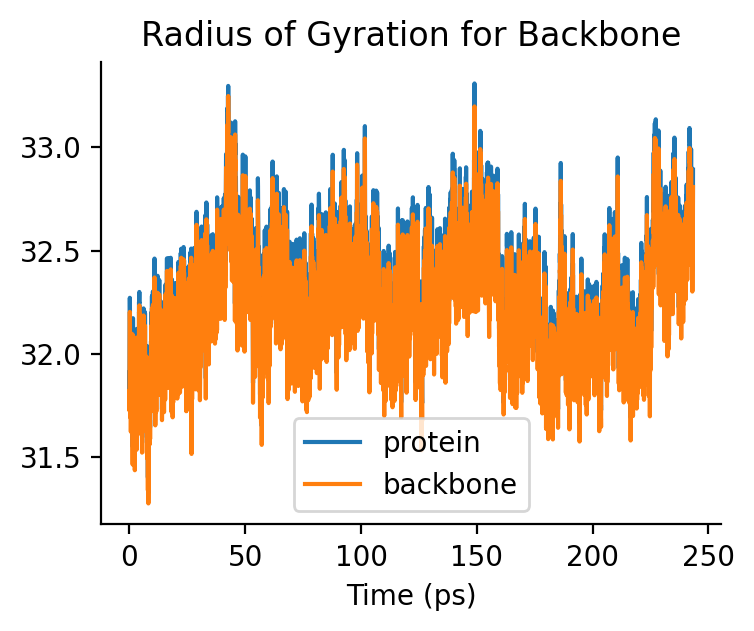

In [5]:
%%time
rad_gy=[]
time = []
frame =[]

for ts in u.trajectory: 
    time.append(u.trajectory.time)
    rad_gy.append(protein.radius_of_gyration())
    frame.append(ts.frame)

rg_df = pd.DataFrame({'Frame' : frame, 'Time (ps)': time, 
                     'radius of gyration A':rad_gy})
ax= rg_df.plot(x='Time (ps)', y= 'radius of gyration A', label = 'protein', 
               figsize=(4, 3))

rg_backbone_df = calculate_rg_for_specific_region(u, region = 'backbone',)
rg_backbone_df.plot(x='Time (ps)', y= 'Radius of Gyration (A)', 
                    title='Radius of Gyration for Backbone', label = 'backbone', ax= ax)
sns.despine()


### Analysis using MDTraj

In [6]:
traj = md.load_dcd(dcd, top=psf)

In [7]:
chains = list(traj.topology.chains)

topology = traj.topology
